In [1]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import get_ensg_id, estimate_s, CCC

In [2]:
plt.rcParams['font.size'] = '18'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data

In [3]:
alldata = sc.read('data/hgForebrainGlut.loom',validate=False)
alldata

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [4]:
alldata.obs.groupby(['Clusters']).size()

Clusters
0    187
1    332
2     94
3    249
4    347
5    243
6    268
dtype: int64

In [5]:
adata = alldata
adata

AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

# Calculate CV$^2$ of read depth

0.07185885259573187 0.17890835555580814


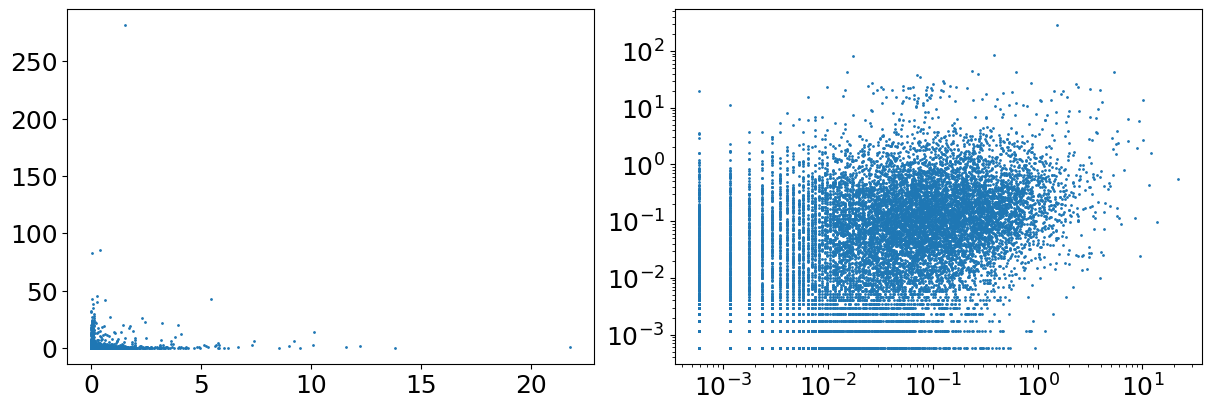

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

s estimated by total counts = 0.10505205246758736
5557 su= 0.13108669011347815
7392 ss= 0.13359388992349164
5713 s= 0.11579381328583986


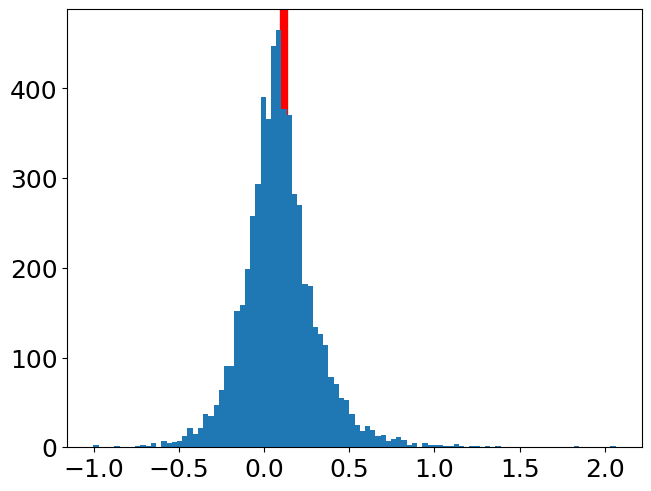

In [7]:
su, ss, sp = estimate_s(adata)

In [8]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.0) & (adata.layers["unspliced"].toarray().mean(0) > 0.0)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
U.sum(),S.sum()

(3949567, 9522726)

Text(0.02, 0.5, 'CV$^2$')

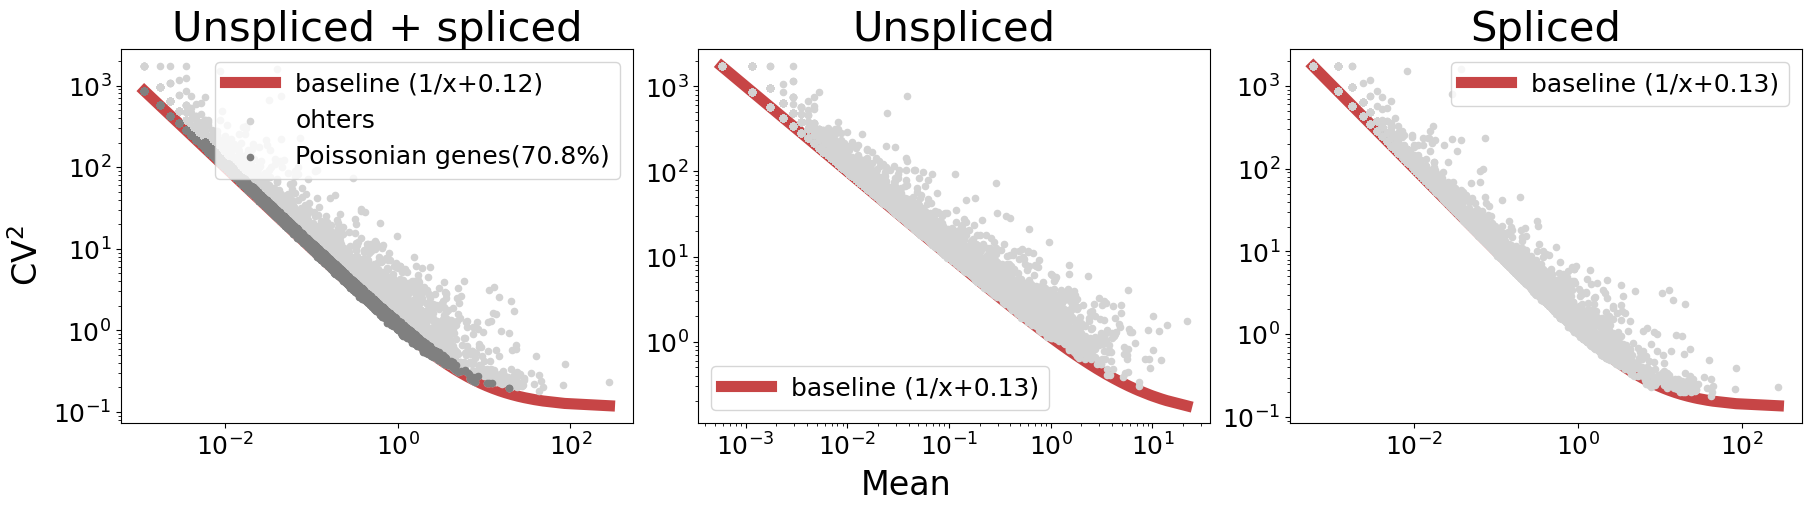

In [11]:
a=1

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(a*X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), a/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), a/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
#ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), a/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
#ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

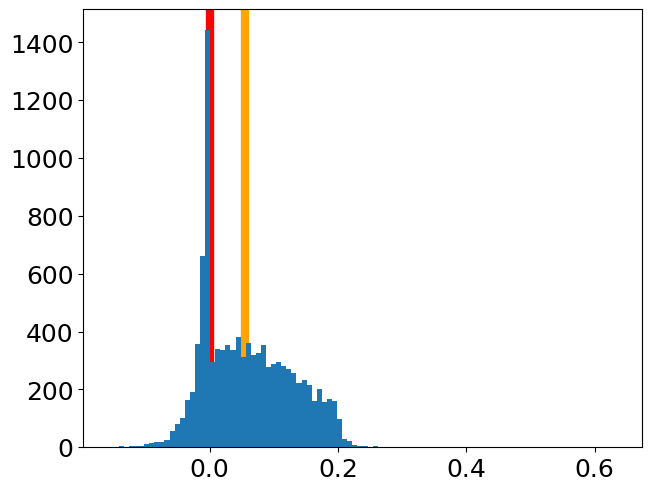

In [12]:
plt.hist((X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask],bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.axvline(x=0.05*(1+sp),c='orange',zorder=0)

# Select one cluster and check CV again

In [47]:
cluster_idx = (alldata.obs['Clusters'].isin([4])) 
adata = alldata[cluster_idx]
adata

View of AnnData object with n_obs × n_vars = 347 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

s estimated by total counts = 0.08817011204365227
5370 su= 0.12746281532959136
7107 ss= 0.11293502308897788
5850 s= 0.1019575552305044


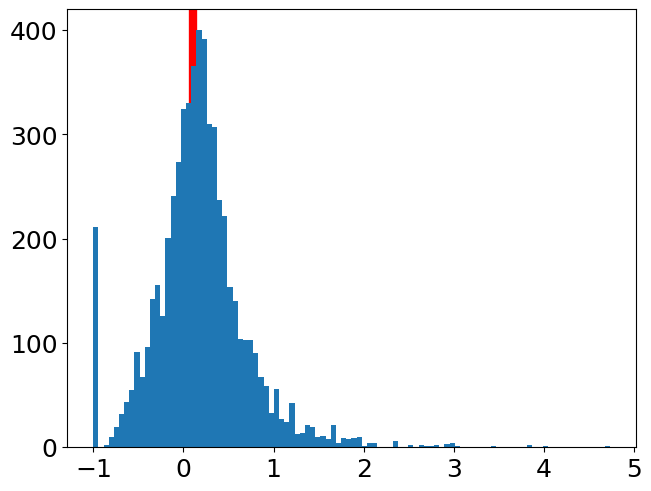

In [48]:
su, ss, sp = estimate_s(adata)

Text(0.02, 0.5, 'CV$^2$')

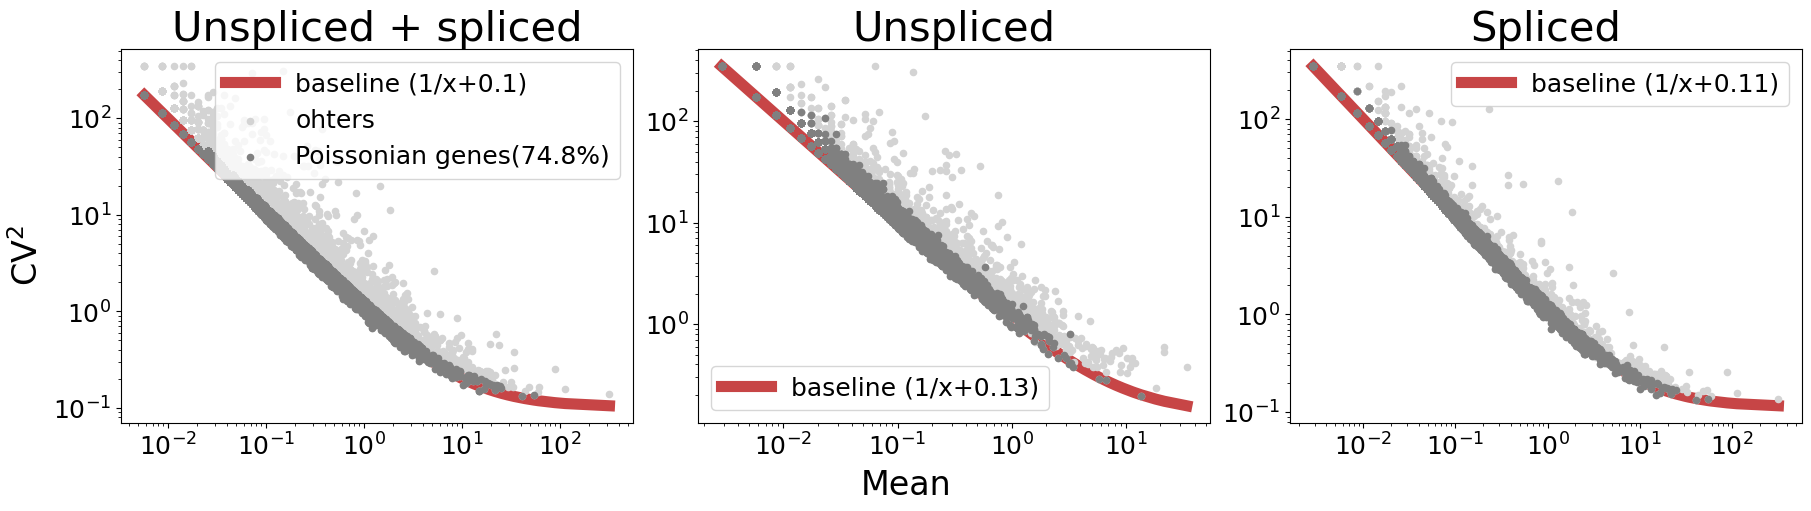

In [49]:
min_mean = 0
idx = (adata.layers["spliced"].toarray().mean(0) > min_mean) & (adata.layers["unspliced"].toarray().mean(0) > min_mean)

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

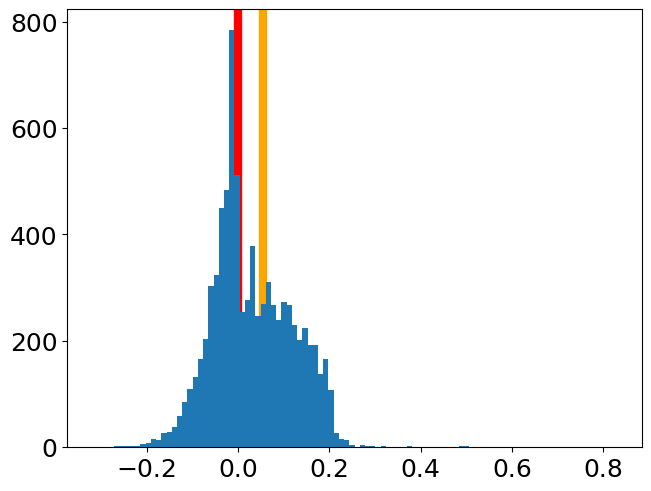

In [50]:
plt.hist((X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask],bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.axvline(x=0.05*(1+sp),c='orange',zorder=0)

# Check covariance relationships

In [51]:
min_mean = 0.5
idx = (adata.layers["spliced"].toarray().mean(0) > min_mean) & (adata.layers["unspliced"].toarray().mean(0) > min_mean)

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

(299,)

## $Var(N_U)$

Text(0.5, 1.0, '99.0% of cells >= 0')

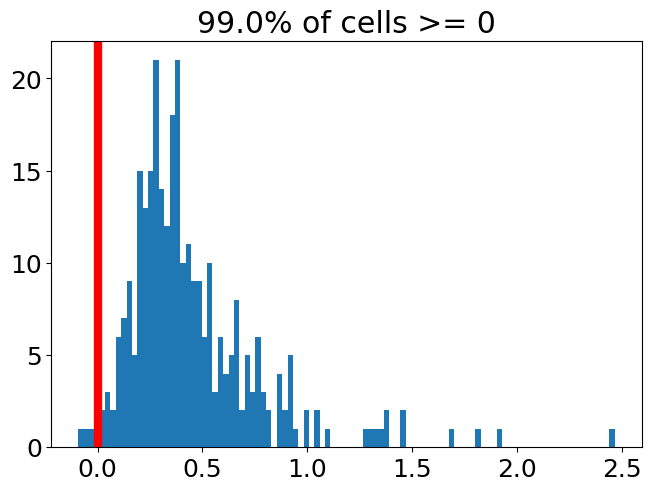

In [52]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')
plt.title(str(np.around(100*(zeta_uu>=0).mean(),2))+'% of cells >= 0')

## $Cov(N_u,N_s)$ 

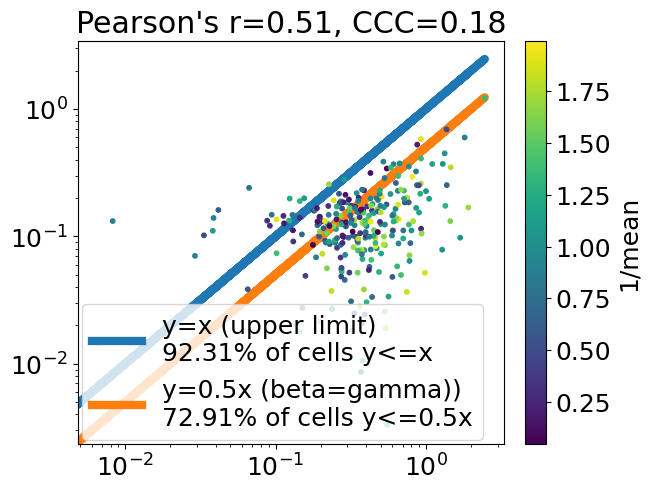

In [53]:
x=zeta_uu
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

## $Var(N_s)$ 

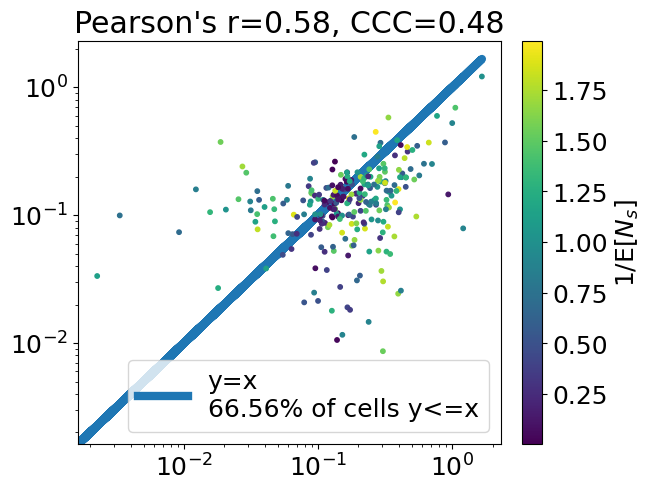

In [54]:
x=zeta_ss
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()